![tabnet_diagram](../images/tabnet.png)
## Introduction
We are talking about [TabNet](https://arxiv.org/abs/1908.07442) today which is a network designed for Tabular data. One aspect that tree based models such as Random Forest (RF) and XgBoost can claim over Neural Nets is the explainability of the model.

Personally, one of the coolest features of this network is the ability for the network to point out which features were used in it's final decision. And these features change from input to input. We have a visual demo using MNIST below. RF does not have this kind of flexibility and is only one static graph for any kind of input.

## Acknowledgement
Kudos to [Paul Tune](https://www.linkedin.com/in/paul-tune-0ba18116/) for pointing out how to configure the loss function in keras. In terms of the actual implementation it was done very much thanks to this [YouTube talk](https://www.youtube.com/watch?v=ysBaZO8YmX8&ab_channel=AbhishekThakur) done by [Sebastien Fischman](https://www.linkedin.com/in/sebastienfischman/) and hosted by [Abhishek Thakur](https://www.linkedin.com/in/abhi1thakur/). Much of the TensorFlow code was very much a reimplimentation of the [PyTorch code](https://github.com/dreamquark-ai/tabnet/blob/develop/pytorch_tabnet/tab_network.py).

In [2]:
#| include: false
!pip install tensorflow_addons

     |████████████████████████████████| 706kB 5.5MB/s 


In [3]:
#| include: false
import multiprocessing as mp

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons.activations import sparsemax

%matplotlib inline

## Model
This section will outline the blocks that we have used in creating the overall model. See the [diagram](tabnet_diagram) above to refer to the sections mentioned below. We will not be talking about part (b) of the diagram as that from my understanding is only used for completing missing values.

### Fully-Connected Block
Let's look at section (c) of the diagram and especially one set of the blue-green-red boxes and call that one Fully-Connected layer. Instead of ReLU the authors have used a GLU activation (the calculation of which is shown in the first two lines). The `FCBlock` will form as one of the building blocks of the entire architecture.

In [4]:
def GLU(x):
    return x * tf.sigmoid(x)

class FCBlock(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.layer = layers.Dense(units)
        self.bn = layers.BatchNormalization()

    def call(self, x):
        return GLU(self.bn(self.layer(x)))

### Feature Transformer
Next bit of the feature transformer in section (c) is the Shared Block and the Decision Block which look extrememly similar. This is why I sub-classed `DecisionBlock` to have parent `SharedBlock`. Also worth mentioning that this is all possible thanks to the new features of TensorFlow 2.0+.

The shared block is simply stacking two `FCBlock`s with a residual connection which is multiplied by `sqrt(0.5)`. I'm not sure if this multiplication is necessary but I will leave it in.

The decision block is almost the same except that there are two residual connections.

Now in terms of functionality, refer to section (a) of the diagram. The user needs to define the number of steps as one of the hyper-parameters. The feature transformer is repeated number of steps + 1 many times. In this, the `SharedBlock` weights are shared across all of that, whereas the `DecisionBlock` weights are different for each step.

In [5]:
class SharedBlock(layers.Layer):
    def __init__(self, units, mult=tf.sqrt(0.5)):
        super().__init__()
        self.layer1 = FCBlock(units)
        self.layer2 = FCBlock(units)
        self.mult = mult

    def call(self, x):
        out1 = self.layer1(x)
        out2 = self.layer2(out1)
        return out2 + self.mult * out1

class DecisionBlock(SharedBlock):
    def __init__(self, units, mult=tf.sqrt(0.5)):
        super().__init__(units, mult)

    def call(self, x):
        out1 = x * self.mult + self.layer1(x)
        out2 = out1 * self.mult + self.layer2(out1)
        return out2

### Attentive Transformer
This is the part where the magic happens. The attentive transformer decides which bits of the input features (x) it needs to pay attention (mask) at each step.

Before, talking about the Attentive transformer we need to talk about the `split` module and the `prior` layers. The split module simply splits the output of the feature transformer into two portions. One portion which feeds into the attentive transformer, and the other which goes into the output of our overall network. The portions (`n_d, n_a`) are hyper-parameters that the user needs to specify and it would sum to the number of output nodes of the decision layer.

The attentive layer takes the `n_a` output nodes from the decision block, runs it through a dense layer and batch norm layer before passing through a `sparsemax` layer. Sparsemax is similar to softmax in that the output sums to one. However, it drives some of the smaller outputs to exactly zero unlike softmax (which can only get close to zero). It is important to note that the dense layer used here projects `n_a` nodes to the same dimensionality as the input features, as we will use this as a mask to select features.

The prior layer is used as a tool to suppress some of the inputs that were used before in a previous step. In the first step none of the input had been used before, and therefore the output of the attentive transformer is unaffected by the prior. However, in the second step (and onwards), the prior is updated to be `prior = previous_prior * (constant - previous_mask)`. The constant mentioned here is a number close to one. Therefore, if the `previous_mask` output by the attentive mask had numbers close to one, the prior is pushed closer to zero, whereas the unused inputs having a mask close to zero, would have a prior closer to one. The priors closer to zero would effectively act as a suppressant before passing into the sparsemax activation in the attentive layer.

The reason that we attempt to use this kind of prior is so that each step attempts to find unique features which adds to the output of the network.

In [6]:
class Prior(layers.Layer):
    def __init__(self, gamma=1.1):
        super().__init__()
        self.gamma = gamma

    def reset(self):
        self.P = 1.0

    def call(self, mask):
        self.P = self.P * (self.gamma - mask)
        return self.P

In [7]:
class AttentiveTransformer(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.layer = layers.Dense(units)
        self.bn = layers.BatchNormalization()

    def call(self, x, prior):
        return sparsemax(prior * self.bn(self.layer(x)))

### Putting it All Together
Much of the architecture has already been discussed in the two previous sections. However, there is two more missing pieces.

Firstly, the loss function. In additional to the loss function that is used for the task (CrossEntropy in the case of MNIST classification), there is an additional loss on the mask values to drive the values towards either 0 or 1. The (entropy) loss is defined as follows:
$$
\begin{align}
L_{mask} = - M \log (M + \epsilon)
\end{align}
$$
The plot below shows entropy as a function of one mask value. We average out all available mask entropy values to get final loss. Note how they are minimised at either extreme.

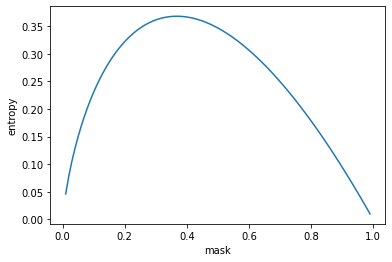

In [8]:
#| echo: false
p = np.arange(0.01, 1, 0.01)
e = - p * np.log(p)
plt.plot(p, e)
plt.xlabel("mask")
plt.ylabel("entropy")
plt.show()

The second part that we have not discussed so far is the actual output of the model. The `n_d` number of inputs that do not go through the attentive layer gets passed through a ReLU activation at each step before being added up for the final output. This is compared against a target by using a task specific loss function (cross-entropy in our case).

One other thing I'd like to bring your attention to (see what I did there?) is the fact that I used a for loop inside the `call` function in the Module below. It might seem like a minor thing, but this kind of flexibility in building a model was not available before to my knowledge.

### Mask Importance
The whole point of building this model was to be able to select features and to be able to explain the model. The way that we calculate feature importance is by calculating the importance of each step, and by multiplying that by the mask.

Step importance is calculated as the sum of the (`n_d`) outputs of the feature transformer.

In [35]:
#| code-fold: true
class TabNet(keras.Model):
    def __init__(self, input_dim, output_dim, steps, n_d, n_a, gamma=1.3):
        super().__init__()
        # hyper-parameters
        self.n_d, self.n_a, self.steps = n_d, n_a, steps
        # input-normalisation
        self.bn = layers.BatchNormalization()
        # Feature Transformer
        self.shared = SharedBlock(n_d+n_a)
        self.first_block = DecisionBlock(n_d+n_a)
        self.decision_blocks = [DecisionBlock(n_d+n_a)] * steps
        # Attentive Transformer
        self.attention = [AttentiveTransformer(input_dim)] * steps
        self.prior_scale = Prior(gamma)
        # final layer
        self.final = layers.Dense(output_dim)

        self.eps = 1e-8
        self.add_layer = layers.Add()

    @tf.function
    def call(self, x):
        self.prior_scale.reset()
        final_outs = []
        mask_losses = []

        x = self.bn(x)
        attention = self.first_block(self.shared(x))[:,:self.n_a]
        for i in range(self.steps):
            mask = self.attention[i](attention, self.prior_scale.P)
            entropy = mask * tf.math.log(mask + self.eps)
            mask_losses.append(
                -tf.reduce_sum(entropy, axis=-1) / self.steps
            )

            prior = self.prior_scale(mask)
            out = self.decision_blocks[i](self.shared(x * prior))
            attention, output = out[:,:self.n_a], out[:,self.n_a:]
            final_outs.append(tf.nn.relu(output))

        final_out = self.add_layer(final_outs)
        mask_loss = self.add_layer(mask_losses)

        return self.final(final_out), mask_loss

    def mask_importance(self, x):
        self.prior_scale.reset()
        feature_importance = 0

        x = self.bn(x)
        attention = self.first_block(self.shared(x))[:,:self.n_a]
        for i in range(self.steps):
            mask = self.attention[i](attention, self.prior_scale.P)

            prior = self.prior_scale(mask)
            out = self.decision_blocks[i](self.shared(x * prior))
            attention, output = out[:,:self.n_a], out[:,self.n_a:]
            step_importance = tf.reduce_sum(tf.nn.relu(output), axis=1, keepdims=True)
            feature_importance += mask * step_importance

        return feature_importance

In [23]:
#| include: false
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((len(x_train), -1)).astype(np.float32)
x_test = x_test.reshape((len(x_test), -1)).astype(np.float32)

## Loss and Fitting
Now this is the part that I thought was strange in the keras API, unless I'm doing something wrong. Looking at the `TabNet` class above, it returns the actual prediction, and the `mask_loss`. From my understanding of loss functions in keras, it is always the "true y" and the "predictions" over which we need to define a loss.

As shown below my initial attempt was to unpack the predictions into logits and mask losses, and then in the next line to take the cross entropy and average out the mask loss. This however resulted in an error.

What did work however, was to define `mask_loss` function defined below which ignores the `y_true` input, and to add the `loss_weights` during `model.compile`. It seems like attempting to add a breakpoint and debug does not seem to work after you run `model.compile`.

In [17]:
#| code-fold: true
from keras.losses import SparseCategoricalCrossentropy

sce = SparseCategoricalCrossentropy(from_logits=True)
reg_sparse = 0.01
def full_loss(y_true, y_pred):
    logits, mask_loss = y_pred
    return sce(y_true, logits) + reg_sparse * mask_loss.mean()

In [36]:
#| code-fold: true
def mask_loss(y_true, mask_losses):
    return tf.reduce_mean(mask_losses)

model = TabNet(784, 10, 2, 10, 10, 1.3)
model.compile(
    'Adam', 
    loss=[sce, mask_loss],
    loss_weights=[1, 0.01]
)
model.fit(
    x_train, 
    y_train, 
    epochs=5, 
    batch_size=256, 
    validation_split=0.15,
    workers=mp.cpu_count()
)

Epoch 1/5
200/200 [==============================] - 24s 96ms/step - loss: 1.7993 - output_1_loss: 1.7842 - output_2_loss: 1.5173 - val_loss: 0.6537 - val_output_1_loss: 0.6461 - val_output_2_loss: 0.7665
Epoch 2/5
200/200 [==============================] - 19s 94ms/step - loss: 0.5893 - output_1_loss: 0.5828 - output_2_loss: 0.6446 - val_loss: 0.2964 - val_output_1_loss: 0.2923 - val_output_2_loss: 0.4080
Epoch 3/5
200/200 [==============================] - 19s 94ms/step - loss: 0.2887 - output_1_loss: 0.2849 - output_2_loss: 0.3869 - val_loss: 0.2182 - val_output_1_loss: 0.2151 - val_output_2_loss: 0.3119
Epoch 4/5
200/200 [==============================] - 19s 95ms/step - loss: 0.2148 - output_1_loss: 0.2118 - output_2_loss: 0.3055 - val_loss: 0.1908 - val_output_1_loss: 0.1882 - val_output_2_loss: 0.2625
Epoch 5/5
200/200 [==============================] - 19s 94ms/step - loss: 0.1764 - output_1_loss: 0.1737 - output_2_loss: 0.2686 - val_loss: 0.1775 - val_output_1_loss: 0.1751 - v

## Results
Model has 91.8% accuracy on test set. See below for calculation.

In [37]:
#| code-fold: true
y_pred = model.predict(x_test)[0].argmax(axis=-1)
(y_pred == y_test).mean()

0.918

Let's see what features got picked up for the first ten images:

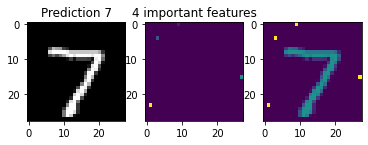

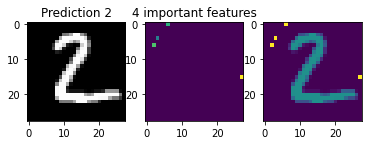

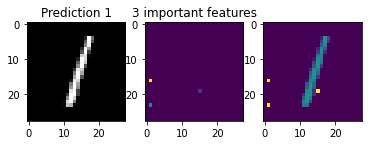

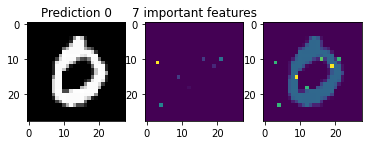

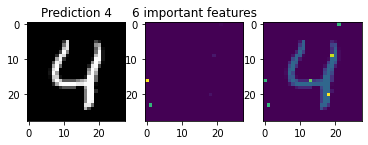

In [46]:
#| echo: false
N = 5
query = x_test[:N]
importance = model.mask_importance(query).numpy()
y_pred = model.predict(query)[0].argmax(axis=-1)

for k in range(N):
    fig, ax = plt.subplots(1, 3)
    img = x_test[k].reshape(28, 28)
    feature_importance = importance[k].reshape(28, 28)
    num_nonzero = (importance[k] != 0).sum()

    ax[0].imshow(img, cmap="gray")
    ax[0].set_title(f"Prediction {y_pred[k]}")
    ax[1].imshow(feature_importance)
    ax[1].set_title(f"{num_nonzero} important features")
    
    ax[2].imshow(img / 500 + (feature_importance!=0).astype(np.float))
    fig.show()

As can be seen in most images the important features on the actual digit itself. However, with the first two images above there are no important features in the actual digit.

It is worth noting that the MNIST digit is not a binary image and even in the far corners the pixel values may not be exactly zero. Alternatively, it is also fathomable to think that the net is making sure that the pixels are zero in certain parts of the image to ensure that the digit is of a certain shape.

## Conclusion
Hopefully that demystified TabNets. I personally feel like the sparsemax activation is not explored enough in other areas of DL and probably has more to contribute in the coming years.

In terms of TabNet, it's great to see explainability being the pure focus of a paper. The experiments conducted in the paper claims that it has beaten XgBoost in some benchmarks and hopefully TabNet will be the gold standard in this space.

Finally, it was really good to play with Tensorflow 2 in a familiar environment to pytorch users.

## Shameless Self Promotion
See [here for my course](https://www.udemy.com/course/machine-learning-and-data-science-2021/?couponCode=DEEPSCHOOL-MARCH) on Machine Learning and Deep Learning (Use code DEEPSCHOOL-MARCH to 85% off).